<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Задача: обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Пороговое значение метрики качества *F1* не меньше 0.75.

**Описание данных**

*text* - содержит текст комментария
*toxic* — целевой признак

## Подготовка

In [1]:
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 12345

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rita/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
df = pd.read_csv('toxic_comments.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df = df.drop('Unnamed: 0', axis=1)
df.sample(5)

,text,toxic
144339,"""\nIn the English language: An electric bass c...",0
157375,"What about some kind of table, like using the ...",0
36227,Blocked \n\nper Wikipedia:Requests for checkus...,0
96393,Hello \n\nI don't know you and I don't take le...,0
34525,Mustafa Kemal Ataturk page and your interferen...,0


In [6]:
df.groupby('toxic').count()

,text
toxic,
0,143106
1,16186


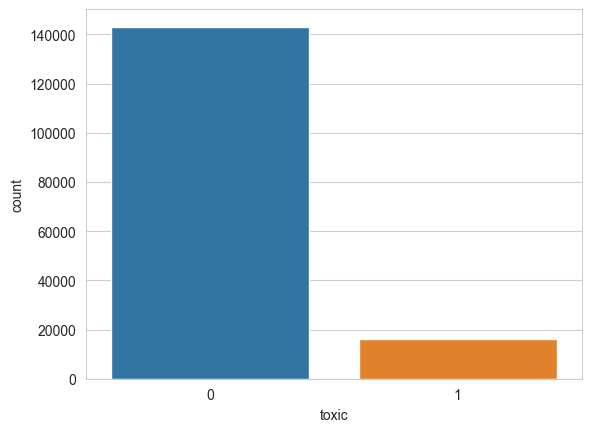

In [7]:
sns.countplot(x='toxic', data=df);

10% твитов не токсичные, а 90% - токсичны. Перед

Предобработаем тексты - приведём все комментарии к нижнему регистру, оставим только латинские буквы (уберем знаки), разобьем текст на слова, удалим стоп-слова, лемматизируем слова, соединим слова в предложение, разделив пробелами.

In [8]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
def do_preprocessing(text, stop_words=None):
    words = re.sub(r'[^a-z]', ' ', text.lower()).split()
    words = [word for word in words if not word in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

    return ' '.join(words)

Произведём предобработку и разделим данные на обучающую и тестовую выборки

In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
%%time
corpus = df['text'].apply(do_preprocessing, stop_words=stop_words)
corpus.head()

CPU times: user 16min 38s, sys: 1min 39s, total: 18min 17s
Wall time: 19min 27s


0    explanation edits make username hardcore metal...
1    aww match background colour seemingly stuck th...
2    hey man really try edit war guy constantly rem...
3    make real suggestion improvement wonder sectio...
4                        sir hero chance remember page
Name: text, dtype: object

In [13]:
features_train, features_test, target_train, target_test = (
    train_test_split(corpus, df['toxic'], test_size=0.3, random_state=RANDOM_STATE))
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((111504,), (111504,), (47788,), (47788,))

In [14]:
count_tf_idf = TfidfVectorizer(ngram_range=(1,1))

In [15]:
features_train = count_tf_idf.fit_transform(features_train)

In [16]:
features_test = count_tf_idf.transform(features_test)

## Обучение

Рассмотрим 3 модели: логистическую регрессию, случайный лес и случайный лес с градиентным бустингом. Подберем параметры с помощью gRidsearchCV, а после - обучим модели и сравним метрики

In [17]:
lgbm = LGBMClassifier()
logreg = LogisticRegression()
rf = RandomForestClassifier()

In [18]:
rf_params = {'n_estimators': [100, 150],
             'max_depth': [4, 6, 8, 10],
             'min_samples_leaf': [1, 2, 3, 4, 5]}

lgbm_params = {
    'max_depth': [10, 12],
    'learning_rate': [0.01, 0.1]}

logreg_params = {
    'C': [0.1, 1.0, 10]
}

In [27]:
grid = GridSearchCV(logreg, param_grid=logreg_params, scoring='f1', cv = 3)

In [28]:
%%time
grid.fit(features_train, target_train)

CPU times: user 1min 12s, sys: 8.23 s, total: 1min 20s
Wall time: 37.9 s


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1.0, 10]}, scoring='f1')

In [29]:
grid.best_params_

{'C': 10}

In [30]:
grid.best_score_

0.760947432863563

In [31]:
grid2 = GridSearchCV(rf, param_grid=rf_params, scoring='f1', cv = 3)

In [32]:
%%time
grid2.fit(features_train, target_train)

CPU times: user 31min 24s, sys: 36.2 s, total: 32min
Wall time: 34min 24s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'n_estimators': [100, 150]},
             scoring='f1')

In [33]:
grid2.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'n_estimators': 100}

In [34]:
grid2.best_score_

0.0

In [35]:
grid3 = GridSearchCV(lgbm, param_grid=lgbm_params, scoring='f1', cv = 3)

In [36]:
%%time
grid3.fit(features_train, target_train)

CPU times: user 13min 15s, sys: 20.9 s, total: 13min 36s
Wall time: 4min 2s


GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [10, 12]},
             scoring='f1')

In [37]:
grid3.best_params_

{'learning_rate': 0.1, 'max_depth': 12}

In [38]:
grid3.best_score_

0.7085734626101337

В среднем, модель логистической регрессии показывает более высокий уровень метрики, чем lgbm. А случайный лес не справился с таким кол-вом признаков.

Проверка на тестовых данных

In [41]:
logreg_model = LogisticRegression(random_state=RANDOM_STATE, C=10)

logreg_model.fit(features_train, target_train)
preds_train = logreg_model.predict(features_train)
preds_test = logreg_model.predict(features_test)


print(f'F1 метрика на обучающей: {f1_score(target_train, preds_train)}')
print(f'F1 метрика на тестовой: {f1_score(target_test, preds_test)}')

F1 метрика на обучающей: 0.911190053285968
F1 метрика на тестовой: 0.7847436336644971


Логистическая регрессия на тестовых данных дает значение f1 = 0.785, что нам абсолютно подходит.

## Выводы

Мы проанализировали датасет интернет-магазина «Викишоп» и обучили несколько моделей классификации.

Мы предобработали текстовые данные: 
- очистили от знаков пунктуации
- привели к нижнему регистру
- лемматизировали слова

Получили необходимое значение f1-метрики.

Наивысшее значение метрики у классификатора логистической регрессии. Все результаты модели lgbm колеблятся в рамках 0.70 - 0.74, что ниже необходимого порога.